<a href="https://colab.research.google.com/github/nakib103/pancancer_classification/blob/master/analyze_output_clustering_from_intermediate_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import model_from_json, load_model
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

In [ ]:
# run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# load model

model = load_model("/content/drive/My Drive/results/model_with_weights_2D_3.h5")

In [ ]:
# load data and label

data = np.load("/content/drive/My Drive/data/data_np_2D.npy")
label = np.load("/content/drive/My Drive/data/label_np_2D.npy")

In [ ]:
# load output of a specific layer


layer_output = np.load("/content/drive/My Drive/data/layer_12_output.npy")

In [ ]:
# Run clustering  for different K

K = [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]
for k in K:
  kmean = KMeans(n_clusters=k, random_state=0)
  kmean.fit(layer_output)
  
  print("==================================")
  
  print("nCluster: ", k)
  print("Silhoutte Score: ", silhouette_score(layer_output, kmean.labels_))
  print("Homogeneity: ", homogeneity_score(label.argmax(axis=1), kmean.labels_))
  print("Completeness: ", completeness_score(label.argmax(axis=1), kmean.labels_))
  print("v_measure_score: ", v_measure_score(label.argmax(axis=1), kmean.labels_))
  print("adjusted_mutual_info_score\(AMI\): ", adjusted_mutual_info_score(label.argmax(axis=1), kmean.labels_))
  print("adjusted_rand_score\(ARI\): ", adjusted_rand_score(label.argmax(axis=1), kmean.labels_))
  
  print("==================================")

In [ ]:
# check metrices of a clustering of a single k

k = 27
kmean = KMeans(n_clusters=k, random_state=0)
kmean.fit(layer_output)
  
print("Silhoutte Score: ", silhouette_score(layer_output, kmean.labels_))
print("Homogeneity: ", homogeneity_score(label.argmax(axis=1), kmean.labels_))
print("Completeness: ", completeness_score(label.argmax(axis=1), kmean.labels_))
print("v_measure_score: ", v_measure_score(label.argmax(axis=1), kmean.labels_))
print("adjusted_mutual_info_score\(AMI\): ", adjusted_mutual_info_score(label.argmax(axis=1), kmean.labels_))
print("adjusted_rand_score\(ARI\): ", adjusted_rand_score(label.argmax(axis=1), kmean.labels_))

In [ ]:
# ensamble clustering

### Ensemble clustering with different random_states
def ensemble_kmeans(data, rnd_states, k_list):
    ## Run clustering with different k and check the metrics
    labs=[]
    for r in rnd_states:
        for k in k_list:
            print(k, r)
            clusterer = KMeans(n_clusters=k, random_state=r)
            clusterer.fit(data)
            labs.append(clusterer.labels_)
    return np.array(labs)
  
rnd_states=[0]
klist=[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35]
cl_data=ensemble_kmeans(layer_output, rnd_states, klist)

In [ ]:
cl_data.shape

(16, 11069)

In [ ]:
#construct a cooccurrence (consensus) matrix

def cons_matrix(labels):
    C=np.zeros([labels.shape[1],labels.shape[1]], np.int32)
    for label in labels:
        for i, val1 in enumerate(label):
            for j, val2 in enumerate(label):
                #filling C_ij
                
                if val1 == val2 :
                    C[i,j] += 1 
                    
                ##and with a list comprehension?
                
    
    return pd.DataFrame(C)
  
C=cons_matrix(cl_data)

g=sns.clustermap(C)
# plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

In [ ]:
# kmean on PCA reduced data for visualization

from sklearn.decomposition import PCA

reduced_data = PCA(n_components=2).fit_transform(layer_output)
kmean_on_pca = KMeans(n_clusters=27, random_state=0)
kmean_on_pca.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=27, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

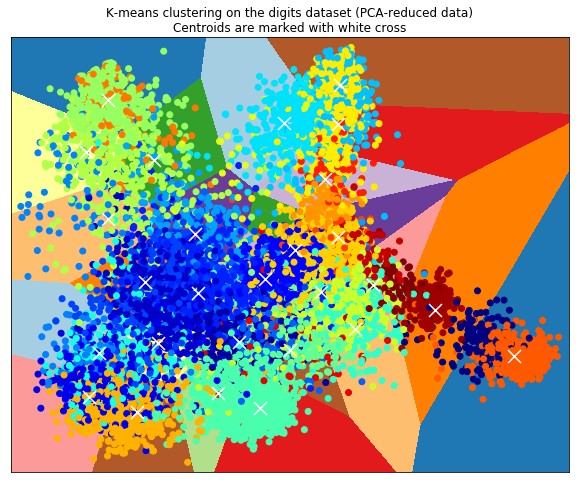

In [ ]:
# visualize the cluster

import matplotlib

# create the mesh
h = 0.02
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmean_on_pca.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10, 8))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

# Plot the reduced data
# define the colormap
cmap = plt.cm.jet
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c = label.argmax(axis=1), cmap=cmap)

# Plot the centroids as a white X
centroids = kmean_on_pca.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()